<a href="https://colab.research.google.com/github/mroshan454/CrossSight_Image_Captioning/blob/main/Pf_CrossSight_Image_Captioning_Using_CNN_Encoder_and_Transformer_Decoder(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Captioning Using CNN Encoder and Transformer Decoder(PyTorch).

In this notebook, I build an **end-to-end image captioning system** that generates natural-language descriptions for images.

The model combines computer vision and natural language processing by using:

- a **CNN encoder** to **extract visual features** from images
- a **Transformer-based decoder** to **generate captions token-by-token.**
- cross-attention to align visual features with text tokens.

This project was built from scratch to deeply understand how vision and language interace inside Transformer Architecture.

### Motivation :

- I wanted to build a system that can **see** and **describe** images - similar to how humans percieve and communicate visual information.

- Beyond performance, the goal of this project is architectural understanding—how images become semantic memory, and how language is generated token by token while attending to that memory.


### Project Scope:

- This project involves :
   -  Data Loading , Parsing data and Building Vocab.
   -  Creating the Dataset to use it for Training.
   -  Building the Model to train, which is CNN as Encoder and Transformer as Decoder.
   -  Assigning Hyper-parameters , Loss Functions and Optimizer.
   -  Training the Model (Training Loop).
   -  Inference and Testing the model after the Training.
   -  Visualising the Results and Saving the Model for Deployement.

This is a Multi-Modal AI project which involves the Image data + Text , which have many usecases like Describing Image for the Blind,
a Robot's vision to understand it's environement, Image Search Engines etc...

### Imports+ Config

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
import cv2
import albumentations as alb
from albumentations.pytorch import ToTensorV2
import timm
import os
import re
from collections import Counter
if torch.cuda.is_available():
  device = "cuda"
else:
   device = "cpu"

## DATASET LOADING + PARSING + VOCABULARY

We use the Flickr8k dataset to focus on architectural correctness and multimodal reasoning rather than scale.


In this section we are doing:
1. Load captions.txt
2. Parse into image -> captions structure
3. Build DataFrame
4. Build Vocabulary (+ special tokens)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/Flickr8KVersion"
CAPTION_FILE = "/content/drive/MyDrive/Flickr8KVersion/captions.txt"
IMG_DIR = os.path.join(BASE_DIR,"Images")
with open(CAPTION_FILE,"r") as f:
   lines = f.readlines()

# Parse captions
# image.jpg,caption text
missing = "2258277193_586849ec62.jpg"

get_captions = {}
all_captions = [] ## ->List of all captions

for line in lines:
     line = line.strip()
     #It must contain a comma
     if "," not in line:
       continue

     #Split only on the first comma
     img_name , caption = line.split(",",1)

     if img_name == missing:
       continue

     caption_list = get_captions.get(img_name,[])
     caption_list.append(caption)
     get_captions[img_name] = caption_list
     all_captions.append(caption)

print(f"Total Images :{len(get_captions)}")
print(f"Total Captions : {len(all_captions)}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total Images :8091
Total Captions : 40455


### Build Dataframe

In [ ]:
df = pd.DataFrame({
    "filename":list(get_captions.keys()),
    "captions":list(get_captions.values())
})

print(df.head())

         filename                                           captions
0           image                                          [caption]
1  1000092795.jpg  [ Two young guys with shaggy hair look at thei...
2    10002456.jpg  [ Several men in hard hats are operating a gia...
3  1000268201.jpg  [ A child in a pink dress is climbing up a set...
4  1000344755.jpg  [ Someone in a blue shirt and hat is standing ...


### Simple Tokenizer + Vocabulary

In [ ]:
## SIMPLE TOKENIZER
def simple_tokenizer(text):
    return re.findall(r"\b\w+\b",text.lower())

##BUILDing VOCABULARY
vocab_frequency = Counter()

for cap in all_captions:
    vocab_frequency.update(simple_tokenizer(cap))

### Special Tokens Assignment
special_tokens = ["<UNK>","<PAD>","<START>","<END>"]

vocab = {tok: idx for idx , tok in enumerate(special_tokens)}

for word in vocab_frequency:
    if word not in vocab:
        vocab[word] = len(vocab)

idx_to_word = {idx: word for word, idx in vocab.items()}

print("Vocabulary Size:",len(vocab))




Vocabulary Size: 18291


### Assigning Context Length

In [ ]:
## Context Length
context_length = 20

## DATASET CLASS

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random

class ImageCaptioningDataset(Dataset):
  def __init__(self,df,img_dir,context_length,split=str):
     self.df = df
     self.img_dir = img_dir
     self.context_length = context_length
     ##### Image Transforms Using Albumentations ######
     ##### Transforms Created Internally ##############
     t = [alb.Resize(224,224)]
     if split == "train":
         t.append(alb.HorizontalFlip(p=0.5))
         t.append(alb.ColorJitter(p=0.5))
     t.append(alb.Normalize())
     t.append(ToTensorV2())

     self.transforms = alb.Compose(t)

  def __len__(self):
      return len(self.df)

  def __getitem__(self,idx):
      row = self.df.iloc[idx] # Row Access
      filename = row["filename"] # Filename Extraction
      #####Image Preprocessing##############
      image_path = os.path.join(self.img_dir,filename) #Joining the image_dir and filename into one image_path
      image = cv2.imread(image_path) #Loads image from filepath using openCV
      if image is None:
         raise RuntimeError(f"Failed to load image: {image_path}")
      image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #Changing BGR color to RGB color , because OpenCV loads image as BGR and we need to convert them to RGB before feeding them to a model.
      image = self.transforms(image=image)["image"] # Applying Transforms --> (3,H,W) tensor
      #####Caption Preprocessing############
      captions = row["captions"] #Extract caption
      caption = random.choice(captions) #Take out one random caption in easy pythonic way
      tokens = simple_tokenizer(caption) #Tokenize one caption

      ids = [vocab.get(word, vocab["<UNK>"]) for word in tokens] # Mapping Unknown
      ids = [vocab["<START>"]] + ids + [vocab["<END>"]] #Prepending <START> and appending <END>

      if len(ids) < self.context_length:
         ids = ids + [vocab["<PAD>"]] * (self.context_length - len(ids))  # Because we want to pad the remaining empty spaces upto context length
      else:
         ids = ids[:self.context_length - 1] + [vocab["<END>"]] # Truncating whatever it is upto context length-1 length and adding <END> token upto that number

      return image, torch.tensor(ids,dtype=torch.long)


Each dataset sample consists of:
- An image tensor of shape (3, 224, 224)
- A tokenized caption sequence of fixed length T

During training:
- One random caption is sampled per image
- Special tokens define sequence boundaries
- Padding and truncation enforce a fixed context length

This design enables autoregressive caption generation while attending to a fixed visual memory from the encoder.


#### After Building the Dataset, we need to Batchify the data which is by using DataLoader() function and adding them into batches like Turning `image : (3,224,224) ---> (B,3,224,224)` and `caption: (T,) ---> (B,T)`. After that next component is the `Encoder Block`, which turns the raw image tensors into compact, semantic feature representation that can be used by the decoder.

In [ ]:
##### Defining Training Dataset #######
training_dataset = ImageCaptioningDataset(
    df,
    IMG_DIR,
    context_length,
    split="train")

###### Dataloader #######
training_dataloader = DataLoader(
    training_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

## MODEL ARCHITECTURE

![MODEL_ARCHITECTURE](https://raw.githubusercontent.com/mroshan454/CrossSight_Image_Captioning/main/Images_and_Diagrams/CrossSight-System-Architecture_Final.png)

## `ENCODER BLOCK`

The two main internal component of the Encoder Block is:
 1. The CNN Backbone
 2. The Linear Projection Layer (Which converts the CNN Output(B,1280) --> (B,512)) Where `1280` is the `output dimension of the CNN` and `512 is the model_dim of the decoder`

The output shape is transformed from:
(B, 1280) → (B, 512) → (B, 1, 512)

This single vector represents a fixed visual memory that remains constant while the decoder generates captions.


In [ ]:
class ImageEncoder(nn.Module):
      def __init__(self,model_dim):
          super().__init__()

          ###Inside __init__ , we only define two key Components###

          ### 1. The CNN Model for Feature Extraction. ###

          self.cnn = timm.create_model(
              "efficientnet_b0",
              pretrained=True,
              num_classes=0
          )
          #Safely finding out the feature size
          dummy_image_tensor = torch.randn(1,3,224,224)
          with torch.no_grad():
            cnn_out = self.cnn(dummy_image_tensor)

          in_features = cnn_out.shape[-1]
          ### 2. The Linear Projection Layer to model_dim. ###
          self.linear_projection_layer = nn.Linear(in_features,model_dim)

      ## Forward Pass
      def forward(self,images):
          ##Pass Images through CNN --> (B,1280)##
          cnn_output = self.cnn(images)
          ##Pass CNN output through Linear Layer -->(B,512)##
          linear_projection_output = self.linear_projection_layer(cnn_output)
          ##Add one extra dimension##
          image_memory = linear_projection_output.unsqueeze(1)

          return image_memory


## `DECODER BLOCK`

The decoder generates captions autoregressively by combining:

- **Masked self-attention** over previously generated tokens
- **Cross-attention** over a fixed image representation from the encoder
- **Token and positional embeddings**
- **Vocabulary projection** to predict the next token

At each timestep, the decoder attends to:
- the caption generated so far (language context)
- the encoded image features (visual context)

This design allows the model to generate coherent captions while grounding each word in the image content.

In [ ]:
class CaptionDecoder(nn.Module):
    def __init__(self,vocab_size,model_dim,context_length,num_heads,num_layers):
      super().__init__()
      ######1. Token Embedding#####
      self.token_embedding = nn.Embedding(vocab_size,model_dim)
      ######2. Position Embedding####
      self.pos_embedding = nn.Embedding(context_length,model_dim)
      ######3. One Decoder Layer
      decoder_layer = nn.TransformerDecoderLayer(
          d_model = model_dim,
          nhead = num_heads,
          dim_feedforward = 4 * model_dim,
          dropout = 0.2,
          batch_first = True
      )
      #####4. Stacking Each Decoder Layer
      self.transformer_decoder = nn.TransformerDecoder(decoder_layer,num_layers=num_layers)

      #####5. Projecting The model_dim -> Vocab Logits
      self.vocab_projection = nn.Linear(model_dim,vocab_size)

      self.context_length = context_length

    def forward(self,tokens,image_memory):
      """
      tokens : (B,T).     int64 token ids
      image_memory: (B,1,C).       From the Encoder (C=model_dim)
      returns logits: (B,T,V)
      """

      B,T = tokens.shape
      device = tokens.device

      # ------1. Initialising Embeddings-----
      tok_emb = self.token_embedding(tokens)
      positions = torch.arange(T,device=tokens.device)
      pos_emb = self.pos_embedding(positions)

      # ------2. Combining Token and Position Embeddings---
      x = tok_emb + pos_emb

      # ------3. Causal Mask For Self Attention------
      tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(device)

      # ------4. Transformer Decoding (Self Attention + Cross Attention)
      decoder_output = self.transformer_decoder(
                     tgt = x,
                     memory=image_memory,
                     tgt_mask=tgt_mask
      )

      logits = self.vocab_projection(decoder_output)

      return logits

Now we have successfully built the Decoder class which returns the Logits as `(B,T,V)`

## Combining `Encoder` and `Decoder` to `Image Captioning Model`

In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self,encoder,decoder):
      super().__init__()
      self.encoder = encoder
      self.decoder = decoder

    def forward(self,images,tokens):
        image_memory = self.encoder(image)
        decoder_logits = self.decoder(tokens,image_memory)

        return decoder_logits

## Training vs. Inference

![TrainingvsInference](https://raw.githubusercontent.com/mroshan454/CrossSight_Image_Captioning/main/Images_and_Diagrams/Training_vs._Inference_Final.drawio.png)

After this we are going to the next main section:

# `TRAINING LOOP`



Before we setup the training loop we need to instantiate the model and add Loss and Optimizer.

### Instantiate Model

In [ ]:
model_dim = 512
image_encoder = ImageEncoder(model_dim).to(device)
caption_decoder = CaptionDecoder(
    vocab_size = len(vocab),
    model_dim=model_dim,
    context_length=context_length,
    num_heads=8,
    num_layers=6
).to(device)

In [ ]:
model = ImageCaptioningModel(
    encoder = image_encoder,
    decoder = caption_decoder
).to(device)

### Loss + Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"])
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

### Training Loop

In [ ]:
epochs = 30

model.train()

for epoch in range(epochs):
    for images , captions in training_dataloader:
        images = images.to(device)             # (B,3,224,224)
        captions = captions.to(device)         # (B,T)

        # ----------------------
        # 1. Shift Captions
        # ----------------------

        inputs  = captions[:,:-1]               # (B,T-1) -> Model Input
        targets = captions[:,1:]                # (B,T-1) -> Ground Truth

        # -----------------------
        # 2. Forward Pass
        # -----------------------

        logits = model(images,inputs)           # (B, T-1, V)

        # -----------------------
        # 3. Compute Loss
        # -----------------------

        B,T,V = logits.shape
        loss = loss_fn(
            logits.reshape(B*T,V),
            targets.reshape(B*T)
        )

        # -----------------------
        # 4. Backpropagation
        # -----------------------

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} : loss = {loss.item():.4f}")

Epoch 1 : loss = 4.3681
Epoch 2 : loss = 3.7154
Epoch 3 : loss = 3.9591
Epoch 4 : loss = 3.2471
Epoch 5 : loss = 3.4882
Epoch 6 : loss = 3.1494
Epoch 7 : loss = 2.7406
Epoch 8 : loss = 2.9777
Epoch 9 : loss = 2.6038
Epoch 10 : loss = 2.7300
Epoch 11 : loss = 2.9387
Epoch 12 : loss = 2.7003
Epoch 13 : loss = 2.2864
Epoch 14 : loss = 2.7664
Epoch 15 : loss = 2.5913
Epoch 16 : loss = 2.4582
Epoch 17 : loss = 2.5859
Epoch 18 : loss = 2.5466
Epoch 19 : loss = 2.1432
Epoch 20 : loss = 2.6496
Epoch 21 : loss = 2.4842
Epoch 22 : loss = 2.1295
Epoch 23 : loss = 2.2658
Epoch 24 : loss = 2.5241
Epoch 25 : loss = 2.3050
Epoch 26 : loss = 2.0711
Epoch 27 : loss = 1.9436
Epoch 28 : loss = 2.0197
Epoch 29 : loss = 2.1193
Epoch 30 : loss = 2.0869


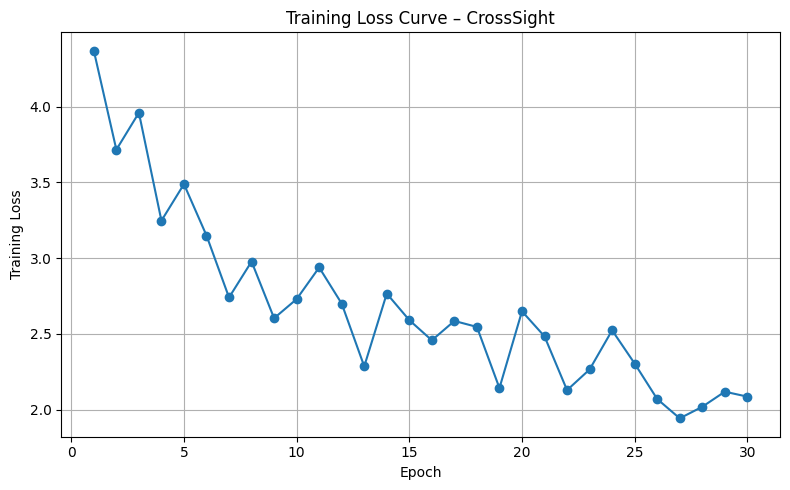

In [ ]:
import matplotlib.pyplot as plt

losses = [
    4.3681, 3.7154, 3.9591, 3.2471, 3.4882,
    3.1494, 2.7406, 2.9777, 2.6038, 2.7300,
    2.9387, 2.7003, 2.2864, 2.7664, 2.5913,
    2.4582, 2.5859, 2.5466, 2.1432, 2.6496,
    2.4842, 2.1295, 2.2658, 2.5241, 2.3050,
    2.0711, 1.9436, 2.0197, 2.1193, 2.0869
]

plt.figure(figsize=(8,5))
plt.plot(range(1, len(losses)+1), losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve – CrossSight")
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()


After the training loop , the next step is `Inference`.


# `INFERENCE`




In [ ]:
def generate_caption(model,image,max_len=20):
    model.eval()
    with torch.inference_mode():
      ### Getting the image and adding 1 extra dimension
      image = image.unsqueeze(0).to(device)
      ### Initializing the token sequence by adding the <START> token using vocab lookup
      tokens = torch.tensor([[vocab["<START>"]]],dtype=torch.long).to(device)

      ## Looping through max_len
      for _ in range(max_len):
          logits = model(image,tokens) # Image -> (B,3,H,W) , Tokens -> (B,T) ------> (B,T,V)
          ### Selecting the Last Timestep only
          next_token_logits = logits[:,-1,:] # Results in (B,V)
          ### Choosing the Next token id
          next_token = next_token_logits.argmax(dim=1)
          ### unsqueeze() to expand the dim for concatenation
          next_token = next_token.unsqueeze(1)
          ### Concatenating to the growing sequence, along the T axis
          tokens = torch.cat([tokens,next_token],dim=1)  # (B,T+1)

          #Stop the loop if we reach <END> token
          if next_token.item() == vocab["<END>"]:
             break


    #Converting Word ids --> Words
    words = []
    for idx in tokens[0].tolist():
        word = idx_to_word[idx]
        if word in ["<START>","<PAD>","<END>"]:
           continue
        words.append(word)

    return " ".join(words)









In [ ]:
# Quick test caption (after training)
sample_img, _ = training_dataset[0]
print("Sample caption:", generate_caption(model, sample_img, max_len=20))

Sample caption: a little girl in a pink dress climbs down a wooden slide


In [ ]:
import matplotlib.pyplot as plt

def show_image(img_tensor):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()  # (H,W,3)
    img = (img - img.min()) / (img.max() - img.min())  # safe normalize
    plt.imshow(img)
    plt.axis("off")


Sample caption: a girl in a pink dress climbing a wooden wall


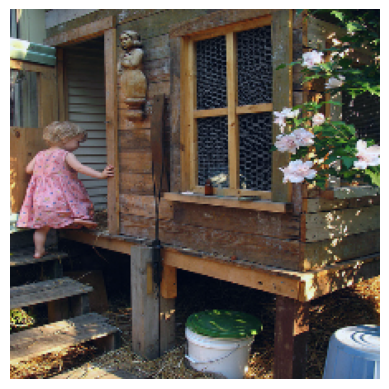

In [ ]:
sample_img, _ = training_dataset[0]

show_image(sample_img)

print("Sample caption:", generate_caption(model, sample_img, max_len=20))


In [ ]:
def decode_caption(token_ids):
    words = []
    for idx in token_ids.tolist():
        word = idx_to_word[idx]
        if word in ["<START>", "<END>", "<PAD>"]:
            continue
        words.append(word)
    return " ".join(words)


Prediction: a black dog and a brown dog are standing on the street
Ground Truth: a black dog and a white dog with brown spots are staring at each other in the street


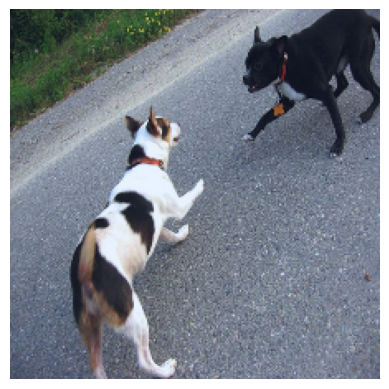

In [ ]:
image, gt_ids = training_dataset[1]

show_image(image)
print("Prediction:", generate_caption(model, image, max_len=20))
print("Ground Truth:", decode_caption(gt_ids))


All Ground Truth Captions:
- A black dog and a spotted dog are fighting
- A black dog and a tri-colored dog playing with each other on the road .
- A black dog and a white dog with brown spots are staring at each other in the street .
- Two dogs of different breeds looking at each other on the road .
- Two dogs on pavement moving toward each other .
Prediction: two dogs are playing together on the street


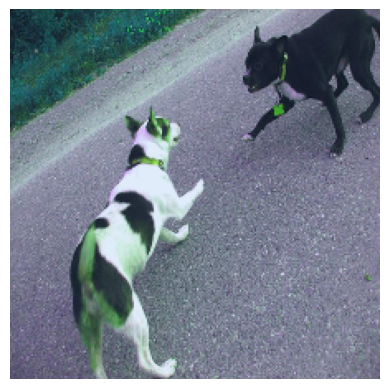

In [ ]:
image, _ = training_dataset[1]
row = df.iloc[1]

print("All Ground Truth Captions:")
for c in row["captions"]:
    print("-", c)

show_image(image)
print("Prediction:", generate_caption(model, image))


In [ ]:
from google.colab import files

torch.save(model.state_dict(), "Image_Captioning_Model_30_Epochs.pt")
files.download("Image_Captioning_Model_30_Epochs.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Deploying The Project using Gradio and Naming `CrossSight`

This is How the Folder should be structured like:

```python3
image-captioning-deploy/
│
├── app.py
├── model.py
├── vocab.py
├── epoch_30.pt
├── requirements.txt
```


Setting up requirements.txt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
cp /content/drive/MyDrive/CrossSight/Cross_Sight_30_Epochs.pt /content/


In [ ]:
mv Cross_Sight_30_Epochs.pt crosssight_deploy/


In [ ]:
ls crosssight_deploy


Cross_Sight_30_Epochs.pt


In [ ]:
with open("vocab.py", "w") as f:
    f.write("vocab = " + repr(vocab) + "\n\n")
    f.write("idx_to_word = " + repr(idx_to_word))


In [ ]:
mv vocab.py crosssight_deploy/


In [ ]:
%%writefile crosssight_deploy/model.py
import torch
from torch import nn
import timm

### Image Encoder

class ImageEncoder(nn.Module):
      def __init__(self,model_dim):
          super().__init__()

          self.cnn = timm.create_model(
              "efficientnet_b0",
              pretrained=True,
              num_classes=0
          )

          dummy = torch.randn(1,3,224,224)
          with torch.no_grad():
               out = self.cnn(dummy)
          in_features = out.shape[-1]
          self.projection = nn.Linear(in_features,model_dim)

      def forward(self,images):
          features = self.cnn(images)   # (B,1280)
          features = self.projection(features) #(B,512)
          return features.unsqueeze(1)

### Caption Decoder

class CaptionDecoder(nn.Module):
    def __init__(self,vocab_size,model_dim,context_length,num_heads,num_layers):
        super().__init__()

        self.token_embedding = nn.Embedding(vocab_size,model_dim)
        self.pos_embedding = nn.Embedding(context_length,model_dim)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model = model_dim ,
            nhead = num_heads,
            dim_feedforward = 4* model_dim,
            dropout = 0.2 ,
            batch_first=True
        )

        self.decoder = nn.TransformerDecoder(decoder_layer,num_layers)
        self.vocab_proj = nn.Linear(model_dim,vocab_size)

    def forward(self,tokens, image_memory):
        B, T = tokens.shape
        device = tokens.device

        tok_emb = self.token_embedding(tokens)
        pos = torch.arange(T,device=device)
        pos_emb = self.pos_embedding(pos)

        x = tok_emb + pos_emb

        causal_mask = nn.Transformer.generate_square_subsequent_mask(T).to(device)

        out = self.decoder(
            tgt=x,
            memory=image_memory,
            tgt_mask=causal_mask
        )

        return self.vocab_proj(out)

## Encoder + Decoder

class ImageCaptioningModel(nn.Module):
    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self,image,tokens):
        image_memory = self.encoder(image)
        return self.decoder(tokens,image_memory)


Writing crosssight_deploy/model.py


In [ ]:
%%writefile crosssight_deploy/app.py
import torch
import gradio as gr
import time
from model import ImageEncoder, CaptionDecoder , ImageCaptioningModel
from vocab import vocab , idx_to_word
import torchvision.transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"


### Load Model

model_dim = 512
context_length = 20

encoder = ImageEncoder(model_dim)
decoder = CaptionDecoder(
    vocab_size=len(vocab),
    model_dim=model_dim,
    context_length=context_length,
    num_heads=8,
    num_layers=6
)

model = ImageCaptioningModel(encoder,decoder)
model.load_state_dict(torch.load("Cross_Sight_30_Epochs.pt",map_location=device))
model.to(device)
model.eval()

# Image Preprocessing

transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5],
                std = [0.5,0.5,0.5])
])

## Animated Caption Generator

def generate_caption(image,max_len=20):

    image = transform(image).unsqueeze(0).to(device)
    tokens = torch.tensor([[vocab["<START>"]]],device=device)

    caption_words = []

    with torch.inference_mode():
      for _ in range(max_len):
          logits = model(image,tokens)      # (1, T,V)
          next_id = logits[:,-1,:].argmax(dim=-1) # (1,)

          if next_id.item() == vocab["<END>"]:
             break

          word = idx_to_word[next_id.item()]
          caption_words.append(word)

          # Animated Typing
          yield " ".join(caption_words)

          tokens = torch.cat([tokens,next_id.unsqueeze(1)], dim=1)
          time.sleep(0.25) #Typing Speed

## Gradio UI

demo = gr.Interface(
    fn = generate_caption,
    inputs = gr.Image(type="pil",label = "Upload Image"),
    outputs = gr.Textbox(label="Generated Caption"),
    title = "Cross Sight👁️",
    description = "A Multimodal Image Captioning System Built from Scratch"
)

demo.launch()

Overwriting crosssight_deploy/app.py


In [ ]:
%%writefile crosssight_deploy/requirements.txt
torch
torchvision
timm
albumentations
opencv-python
gradio
numpy
Pillow

Overwriting crosssight_deploy/requirements.txt


In [ ]:
ls crosssight_deploy


app.py                    model.py   requirements.txt
Cross_Sight_30_Epochs.pt  README.md  vocab.py


In [ ]:

!cd crosssight_deploy && zip -r ../CrossSight_deploy.zip * -x ".pyc" "*.ipynb" "*_pycache_" "*ipynb_checkpoints*"

  adding: app.py (deflated 51%)
  adding: Cross_Sight_30_Epochs.pt (deflated 8%)
  adding: model.py (deflated 66%)
  adding: README.md (deflated 32%)
  adding: requirements.txt (deflated 8%)
  adding: vocab.py (deflated 61%)


In [ ]:
# Download
try:
  from google.colab import files
  files.download("CrossSight_deploy.zip")
except:
  print(f"Not running in Google Colab , can't use google.colab.files.download(), please download manually")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Limitations and Future Work

- Trained on Flickr8k for architectural clarity rather than scale
- CNN encoder is frozen for simplicity
- Future extensions could include beam search, larger datasets, or ViT-based encoders
